In [1]:
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.models import Sequential
from keras.regularizers import l1, l2
from tensorflow.keras import initializers
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.callbacks import EarlyStopping
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import KFold
import keras_tuner
import keras
from keras import layers
import itertools
from sklearn.model_selection import train_test_split
from keras.optimizers import SGD
from keras.callbacks import EarlyStopping
from keras.callbacks import LearningRateScheduler
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.preprocessing import OneHotEncoder
import keras.backend as K
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from math import ceil
from keras.losses import mean_squared_error
import random

seed = 7

2023-01-15 00:26:06.075530: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-15 00:26:06.250030: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-01-15 00:26:07.047845: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-01-15 00:26:07.047936: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or 

In [2]:
def plot_curves(curve_1, label_1, curve_2=None, label_2=None):
    if curve_1 is not None: 
        plt.plot(curve_1, label = label_1, color="black")
    if curve_2 is not None: 
        plt.plot(curve_2, label = label_2, linestyle='dashed', color="grey")   
    plt.legend()
    plt.show()

def set_random_seeds():
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    tf.keras.utils.set_random_seed(seed)

In [3]:
x_scaler = None
y_scaler = None

def load_monks(path, encode):
    
    train = pd.read_csv(f"{path}.train", header=None, sep=" ")
    test = pd.read_csv(f"{path}.test", header=None, sep=" ")
    
    train.drop(0, axis=1, inplace=True)
    test.drop(0, axis=1, inplace=True)
    train.drop(8, axis=1, inplace=True)
    test.drop(8, axis=1, inplace=True)
    
    y_train = train.iloc[:, 0].to_numpy().astype(np.float64)
    x_train = train.iloc[:, 1:].to_numpy().astype(np.float64)
    y_test = test.iloc[:, 0].to_numpy().astype(np.float64)
    x_test = test.iloc[:, 1:].to_numpy().astype(np.float64)
    
        
    if encode:
        
        encoder = OneHotEncoder()
        
        encoder.fit(x_train)
        x_train = encoder.transform(x_train).toarray()
        x_test = encoder.transform(x_test).toarray()
        
        
    
    print(f"Loaded {path} dataset")
    
    return x_train, y_train, x_test, y_test
    

def load_cup(scale):
    global x_scaler
    global y_scaler
    
    x_scaler = MinMaxScaler()
    y_scaler = MinMaxScaler()
    x_scaler = StandardScaler()
    y_scaler = StandardScaler()
    # scaler = MinMaxScaler()
    
    train = pd.read_csv("../data/ML-CUP22-INTERNAL-TR.csv", header=None, sep=",")
    test = pd.read_csv("../data/ML-CUP22-INTERNAL-TS.csv", header=None, sep=",")
    train.drop(0, axis=1, inplace=True)
    test.drop(0, axis=1, inplace=True)

    x_train = train.iloc[:, :9].to_numpy().astype(np.float64)
    y_train = train.iloc[:, 9:].to_numpy().astype(np.float64)

    x_test = test.iloc[:, :9].to_numpy().astype(np.float64)
    y_test = test.iloc[:, 9:].to_numpy().astype(np.float64) 
    # x_test_blind = test.to_numpy().astype(np.float64)
    
    # x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.1, shuffle=True, random_state=7)
    
    if scale:
        x_scaler.fit(x_train)
        x_train = x_scaler.transform(x_train)
        x_test = x_scaler.transform(x_test)
        
        y_scaler.fit(y_train)
        y_train = y_scaler.transform(y_train)
        y_test = y_scaler.transform(y_test)
        
        
    return x_train, y_train, x_test, y_test #, x_test_blind
    
    
    
def load_dataset(dataset, encode=True):
    assert dataset in ["monks1", "monks2", "monks3", "cup"]
    
    if dataset == "monks1":
        return load_monks("./../data/monks-1", encode)
    elif dataset == "monks2":
        return load_monks("./../data/monks-2", encode)
    elif dataset == "monks3":
        return load_monks("./../data/monks-3", encode)
    else:
        return load_cup(encode)

In [4]:
def median_index(array):
    n = len(array)
    med_idx = np.argsort(array)[ceil((n-1)/2)]
    # med_val = array[med_idx]
    return med_idx #, med_val

def mee(y_true_t, y_pred_t):
    return tf.reduce_mean(tf.sqrt(tf.reduce_sum(tf.square(y_true_t - y_pred_t), axis=1)))
    
    
def mse(y_true_t, y_pred_t):
    return tf.reduce_mean(tf.reduce_sum(tf.square(y_true_t - y_pred_t), axis=1))


def merge_dicts(dicts):
    merged = {}
    for d in dicts:
        merged = {**merged, **d}
    return merged


def get_attributes_num(dataset):
    return 1 if len(dataset.shape) == 1 else dataset.shape[1]


def get_params_configurations(params):
    
    keys = list(params.keys())
    keys.remove("layers")
    keys.remove("task")
    keys.remove("initialization")
    keys.remove("early_stopping")
    keys.remove("regularization")
    keys.remove("nesterov")
    keys.remove("trials_train")
    keys.remove("trials_test")
    keys.remove("learning_rate_decay")
    sorted_keys = sorted(keys)
    arguments = []
    for key in sorted_keys:
        arguments.append(params[key])
    
    arguments = tuple(arguments)
    all_params = list(itertools.product(*arguments))
        
    configurations = []
    
    for conf in all_params:
        
        dict_conf = {}
        
        for i in range(len(sorted_keys)):
            dict_conf[sorted_keys[i]] = conf[i]
        dict_conf["initialization"] = params["initialization"]
        dict_conf["early_stopping"] = params["early_stopping"]
        dict_conf["task"] = params["task"]
        dict_conf["trials_train"] = params["trials_train"]
        dict_conf["trials_test"] = params["trials_test"]
        dict_conf["nesterov"] = params["nesterov"]
        dict_conf["learning_rate_decay"] = params["learning_rate_decay"]
        
        # add regularization parameters
        for reg in params["regularization"]:
            method = reg["type"]
            
            if method == None:
                reg_dict_conf = dict_conf.copy()
                reg_dict_conf["regularization"] = {
                    "method": None
                }
                configurations.append(reg_dict_conf)
                continue
            
            for val in reg["value"]:
                reg_dict_conf = dict_conf.copy()
                reg_dict_conf["regularization"] = {
                    "method": method,
                    "value": val
                }
        
                configurations.append(reg_dict_conf)
            
        
    return configurations


def get_callbacks(config):
    
    lr_decay = config["learning_rate_decay"]
    early_stopping = config["early_stopping"]
    
    callbacks = []
    
    if early_stopping != None:
        early_stop = EarlyStopping(
            monitor=early_stopping["monitor"], 
            patience=early_stopping["patience"], 
            min_delta=early_stopping["delta"], 
        )
        callbacks.append(early_stop)

    if lr_decay != None:
        decay_epochs = lr_decay["epochs"]
        lr_final = lr_decay["lr_final"]
        linear_scheduler = get_linear_scheduler(decay_epochs, lr_final)
        scheduler = LearningRateScheduler(linear_scheduler)
        callbacks.append(scheduler)
        
    return callbacks if callbacks != [] else None
        
    
class TestCallback(tf.keras.callbacks.Callback):
    def __init__(self, x_test, y_test, task):
        self.x_test = x_test
        self.y_test = y_test
        self.task = task

    def on_epoch_end(self, epoch, logs):        
        if self.task == "classification":
            loss, acc = self.model.evaluate(self.x_test, self.y_test, verbose=0)
            logs['test_accuracy'] = acc
            logs["test_loss"] = loss
        if self.task == "regression":
            mse_test, mee_test = self.model.evaluate(self.x_test, self.y_test, verbose=0)
            logs['test_loss'] = mse_test
            logs["test_mee"] = mee_test


def get_layers_configurations(params, configurations):
    layers = params["layers"]
    layers_params_confs = []
    
    for n_layer in range(len(layers)):
        layers_params_confs.append([]) 
    
    for i in range(len(layers)):
        layer = layers[i]
        activations = layer["activations"]
        units = layer["units"]
        layer_confs = list(itertools.product(activations, units))
        for conf in layer_confs:
            conf_dict = {
                f"activations_{i+1}": conf[0],
                f"units_{i+1}": conf[1]
            }
            layers_params_confs[i].append(conf_dict)
        
    layers_confs = []
    for i in range(len(layers_params_confs)):
        confs = layers_params_confs[:i+1]
        confs = tuple(confs)
        confs = list(itertools.product(*confs))
        for conf in confs:
            layers_confs.append(merge_dicts(conf))
                
    return layers_confs



def get_configurations(params):
    
    configurations = get_params_configurations(params)
    layers_confs = get_layers_configurations(params, configurations)
    configurations = list(itertools.product(configurations, layers_confs))
    configurations_merged = []
    
    for conf in configurations:
        configurations_merged.append(merge_dicts(conf))
        
    
    return configurations_merged

            

def get_linear_scheduler(epochs, lr_final):
    
    def linear_scheduler(epoch, lr):
        if (epoch < epochs):
            alpha = epoch/epochs
            return (1-alpha)*lr + alpha*lr_final
        else:
            return lr_final
        
    return linear_scheduler
    

def get_model(config, input_size, output_size):
    
    lr = config["learning_rate"]
    momentum = config["momentum"]
    init_method = config["initialization"]["type"]
    task = config["task"]
    nesterov = config["nesterov"]
    
    reg_method = config["regularization"]["method"]
    
    if reg_method == "l1":
        reg_value = config["regularization"]["value"]
        reg = l1(reg_value)
    elif reg_method == "l2":
        reg_value = config["regularization"]["value"]
        reg = l2(reg_value)
    else:
        reg = None
    
    
    init = None
    if init_method == "uniform":
        min_val = config["initialization"]["min"]
        max_val = config["initialization"]["max"]
        init = initializers.RandomUniform(minval=min_val, maxval=max_val, seed=None)
    if init_method == "normal":
        mean = config["initialization"]["mean"]
        std = config["initialization"]["std"]
        init = initializers.RandomNormal(mean=mean, stddev=std, seed=None)
        
    
    if momentum != None:
        optimizer = SGD(learning_rate=lr, momentum=momentum, nesterov=nesterov)
    else:
        optimizer = SGD(learning_rate=lr)
    
    n_layers = 0
    for key in config.keys():
        if key.startswith("units_"):
            n_layers += 1

    model = Sequential()
    model.add(Input(input_size))
    
    for l in range(1,n_layers+1):
        activation = config[f"activations_{l}"]
        n_units = config[f"units_{l}"]
        
        if init != None:
            model.add(Dense(n_units, activation=activation,
                            kernel_regularizer=reg, bias_regularizer=reg,
                            kernel_initializer = init, bias_initializer=init))
        else:
            model.add(Dense(n_units, activation=activation,
                            kernel_regularizer=reg, bias_regularizer=reg))

        
        
    if task == "classification":
        
        if init != None:
            model.add(Dense(output_size, activation="sigmoid",
                            kernel_regularizer=reg, bias_regularizer=reg,
                            kernel_initializer = init, bias_initializer=init))
        else:
            model.add(Dense(output_size, activation="sigmoid",
                            kernel_regularizer=reg, bias_regularizer=reg))
        
        model.compile(optimizer = optimizer, loss = 'mean_squared_error', metrics = ['accuracy'])
        
    elif task == "regression":
        
        if init != None:
            model.add(Dense(output_size, activation="linear",
                            kernel_regularizer=reg, bias_regularizer=reg,
                            kernel_initializer = init, bias_initializer = init))
        else:
            model.add(Dense(output_size, activation="linear",
                            kernel_regularizer=reg, bias_regularizer=reg))
        
        model.compile(optimizer = optimizer, loss = 'mean_squared_error', metrics = [mee])
        
    return model
    
    
def fit_model_k_fold(x_train, y_train, config, n_folds):
    
    task = config["task"]
    
    if task == "classification":
        train_metric = "accuracy"
        val_metric = "val_accuracy"
    elif task == "regression":
        train_metric = "mee"
        val_metric = "val_mee"
    
    trials = config["trials_train"]
    max_epochs = config["max_epochs"]
    batch_size = config["batch_size"]
    
    callbacks = get_callbacks(config)

    
    kf = KFold(n_splits = n_folds, shuffle=True)

    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []

    fold = 1
    for train_index, val_index in kf.split(x_train, y_train):
        
        print(f"\nExecuting fold {fold}/{n_folds}")
        
        input_size = get_attributes_num(x_train)
        output_size = get_attributes_num(y_train)
        
                
        x_train_fold = x_train[train_index]
        y_train_fold = y_train[train_index]

        x_val_fold = x_train[val_index]
        y_val_fold = y_train[val_index]

        
        trials_val_loss = []
        trials_train_loss = []
        trials_val_acc = []
        trials_train_acc = []
        
        with tqdm(total=trials) as pbar:
            for trial in range(trials):
                model = get_model(config, input_size, output_size)
                history = model.fit(x_train_fold, y_train_fold, epochs=max_epochs,
                                    validation_data=(x_val_fold, y_val_fold),
                                    callbacks=callbacks, verbose = 0)

                trial_train_loss = history.history["loss"]
                trial_val_loss = history.history["val_loss"]         
                trial_train_acc = history.history[train_metric]
                trial_val_acc = history.history[val_metric]

                trials_val_loss.append(trial_val_loss[-1])
                trials_train_loss.append(trial_train_loss[-1])
                trials_val_acc.append(trial_val_acc[-1])
                trials_train_acc.append(trial_train_acc[-1])

                pbar.update(1)
            
        # get the median metrics among the trials
        med_idx = median_index(trials_val_loss)
        med_val_loss = trials_val_loss[med_idx]
        med_train_loss = trials_train_loss[med_idx]
        med_val_acc = trials_val_acc[med_idx]
        med_train_acc = trials_train_acc[med_idx]
        std_val_loss = np.std(trials_val_loss)
        std_train_loss = np.std(trials_train_loss)
        std_val_acc = np.std(trials_val_acc)
        std_train_acc = np.std(trials_train_acc)

        print(f"Fold {fold}/{n_folds} median val_loss: {med_val_loss}, std val_loss {std_val_loss}")
        print(f"Fold {fold}/{n_folds} median train_loss: {med_train_loss}, std train_loss {std_train_loss}")
        print(f"Fold {fold}/{n_folds} median {val_metric}: {med_val_acc}, std {val_metric} {std_val_acc}")
        print(f"Fold {fold}/{n_folds} median train_{train_metric}: {med_train_acc}, train_{train_metric} {std_train_acc}")
            
        train_losses.append(med_train_loss)
        val_losses.append(med_val_loss)
        val_accs.append(med_val_acc)
        train_accs.append(med_train_acc)
        
        fold += 1
        
    mean_train_loss = np.mean(train_losses)
    mean_val_loss = np.mean(val_losses)
    mean_train_acc = np.mean(train_accs)
    mean_val_acc = np.mean(val_accs)
    std_train_loss = np.std(train_losses)
    std_val_loss = np.std(val_losses)
    std_train_acc = np.std(train_accs)
    std_val_acc = np.std(val_accs)
    
    print(f"\nMean val_loss: {mean_val_loss}, std val_loss: {std_val_loss}")
    print(f"Mean train_loss: {mean_train_loss}, std train_loss: {std_train_loss}")
    print(f"Mean {val_metric}: {mean_val_acc}, std {val_metric}: {std_val_acc}")
    print(f"Mean train_{train_metric}: {mean_val_acc}, std train_{train_metric}: {std_train_acc}")
    
    return mean_val_loss




def fit_model_hold_out(x_train, y_train, config, val_split):
    
    task = config["task"]
    
    if task == "classification":
        train_metric = "accuracy"
        val_metric = "val_accuracy"
    elif task == "regression":
        train_metric = "mee"
        val_metric = "val_mee"
        
    trials = config["trials_train"]
    input_size = get_attributes_num(x_train)
    output_size = get_attributes_num(y_train)
    
    
    max_epochs = config["max_epochs"]
    batch_size = config["batch_size"]

    
    callbacks = get_callbacks(config)
    
    if task == "classification":
        stratify = y_train
    else:
        stratify = None
        
        
    x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=val_split, shuffle=True, stratify=stratify)

    
    trials_val_loss = []
    trials_train_loss = []
    trials_val_acc = []
    trials_train_acc = []
        
    with tqdm(total=trials) as pbar:
        for trial in range(trials):            
            model = get_model(config, input_size, output_size)
            history = model.fit(x_train, y_train, epochs=max_epochs, batch_size=batch_size,
                                verbose=0, validation_data=(x_val, y_val), callbacks=callbacks)
            

            trial_train_loss = history.history["loss"]
            trial_val_loss = history.history["val_loss"]         
            trial_train_acc = history.history[train_metric]
            trial_val_acc = history.history[val_metric]
            
            trials_val_loss.append(trial_val_loss[-1])
            trials_train_loss.append(trial_train_loss[-1])
            trials_val_acc.append(trial_val_acc[-1])
            trials_train_acc.append(trial_train_acc[-1])
            
            pbar.update(1)
    
    # get the median metrics among the trials
    med_idx = median_index(trials_val_loss)
    med_val_loss = trials_val_loss[med_idx]
    med_train_loss = trials_train_loss[med_idx]
    med_val_acc = trials_val_acc[med_idx]
    med_train_acc = trials_train_acc[med_idx]
    std_val_loss = np.std(trials_val_loss)
    std_train_loss = np.std(trials_train_loss)
    std_val_acc = np.std(trials_val_acc)
    std_train_acc = np.std(trials_train_acc)

    print(f"\nMedian val_loss: {med_val_loss}, std val_loss {std_val_loss}")
    print(f"Median train_loss: {med_train_loss}, std train_loss {std_train_loss}")
    print(f"Median {val_metric}: {med_val_acc}, std {val_metric} {std_val_acc}")
    print(f"Median train_{train_metric}: {med_train_acc}, train_{train_metric} {std_train_acc}")
    
    return med_val_loss
    
    

def fit_final_model(x_train, y_train, x_test, y_test, config):
    global y_scaler
    
    task = config["task"]
    trails = config["trials_test"]
    
    if task == "classification":
        train_metric = "accuracy"
        val_metric = "val_accuracy"
        test_metric = "test_accuracy"
    elif task == "regression":
        train_metric = "mee"
        val_metric = "val_mee"
        test_metric = "test_mee"
    val_loss = "val_mse"
    train_loss = "mse"
    test_loss = "test_mse"

    max_epochs = config["max_epochs"]
    batch_size = config["batch_size"]
    trials = config["trials_test"]
    
    '''if config["early_stopping"]["monitor"] == "val_loss":
        config["early_stopping"]["monitor"] = "loss"'''
        
    callbacks = get_callbacks(config)
    callbacks.append(TestCallback(x_test, y_test, task))
    
    input_size = get_attributes_num(x_train)
    output_size = get_attributes_num(y_train)
    
    
    trials_val_loss = []
    trials_train_loss = []
    trials_val_acc = []
    trials_train_acc = []
    trials_test_acc = []
    trials_test_loss = []
    
    trials_history_val_loss = []
    trials_history_train_loss = []
    trials_history_val_acc = []
    trials_history_train_acc = []
    trials_history_test_acc = []
    trials_history_test_loss = []
    
    models = []
    
    if task == "classification":
        stratify = y_train
    else:
        stratify = None
    
    x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, shuffle=True, stratify=stratify)
    
    with tqdm(total=trials) as pbar:
        for trial in range(trials):
            
            model = get_model(config, input_size, output_size)
            history = model.fit(x_train, y_train, epochs=max_epochs, validation_data=(x_val, y_val),
                                batch_size=batch_size, verbose=0, callbacks=callbacks)

            models.append(model)
            
            trial_train_loss = history.history["loss"]
            trial_val_loss = history.history["val_loss"]
            trial_test_loss = history.history["test_loss"]
            trial_train_acc = history.history[train_metric]
            trial_val_acc = history.history[val_metric]
            trial_test_acc = history.history[test_metric]

            trials_val_loss.append(trial_val_loss[-1])
            trials_train_loss.append(trial_train_loss[-1])
            trials_test_loss.append(trial_test_loss[-1])
            trials_val_acc.append(trial_val_acc[-1])
            trials_train_acc.append(trial_train_acc[-1])
            trials_test_acc.append(trial_test_acc[-1])
            

            trials_history_val_loss.append(trial_val_loss)
            trials_history_train_loss.append(trial_train_loss)
            trials_history_test_loss.append(trial_test_loss)
            trials_history_val_acc.append(trial_val_acc)
            trials_history_train_acc.append(trial_train_acc)
            trials_history_test_acc.append(trial_test_acc)
            

            print(f"Trial {trial+1}/{trials} {val_loss}: {trial_val_loss[-1]}")
            print(f"Trial {trial+1}/{trials} train_{train_loss}: {trial_train_loss[-1]}")
            # print(f"Trial {trial+1}/{trials} {test_loss}: {trial_test_loss[-1]}")
            print(f"Trial {trial+1}/{trials} {val_metric}: {trial_val_acc[-1]}")
            print(f"Trial {trial+1}/{trials} train_{train_metric}: {trial_train_acc[-1]}")
            # print(f"Trial {trial+1}/{trials} {test_metric}: {trial_test_acc[-1]}")

            pbar.update(1)
        
    # get the mean metrics among the trials
    med_idx = median_index(trials_val_loss)
    med_val_loss = trials_val_loss[med_idx]
    med_train_loss = trials_train_loss[med_idx]
    med_val_acc = trials_val_acc[med_idx]
    med_train_acc = trials_train_acc[med_idx]
    std_val_loss = np.std(trials_val_loss)
    std_train_loss = np.std(trials_train_loss)
    std_val_acc = np.std(trials_val_acc)
    std_train_acc = np.std(trials_train_acc)
    
    print(f"\nMedian {val_loss}: {med_val_loss}, std {val_loss}: {std_val_loss}")
    print(f"Median train_{train_loss}: {med_train_loss}, std train_{train_loss}: {std_train_loss}")
    print(f"Median {val_metric}: {med_val_acc}, std {val_metric}: {std_val_acc}")
    print(f"Median train_{train_metric}: {med_train_acc}, std train_{train_metric}: {std_train_acc}")
        
    train_acc = trials_history_train_acc[med_idx]
    test_acc = trials_history_test_acc[med_idx]
    val_acc = trials_history_val_acc[med_idx]
    
    train_loss = trials_history_train_loss[med_idx]
    test_loss = trials_history_test_loss[med_idx]
    val_loss = trials_history_val_loss[med_idx]
    
    
    print(f"\nMedian model train_loss: {train_loss[-1]}")
    print(f"Median model val_loss: {val_loss[-1]}")
    print(f"Median model test_loss: {test_loss[-1]}")
    
    print(f"\nMedian model train_{train_metric}: {train_acc[-1]}")
    print(f"Median model {val_metric}: {val_acc[-1]}")
    print(f"Median model {test_metric}: {test_acc[-1]}")
    
    
    plot_curves(train_acc, f"Training {train_metric}", test_acc, f"Test {train_metric}")
    plot_curves(train_acc, f"Training {train_metric}", val_acc, f"Validation {val_metric}")
    
    plot_curves(train_loss, "Train loss", test_loss, "Test loss")
    plot_curves(train_loss, "Train loss", val_loss, "Validation loss")
    
    med_model = models[med_idx]
    
    if task == "regression":
    
        y_pred = med_model.predict(x_val)
        y_pred = y_scaler.inverse_transform(y_pred)
        y_val = y_scaler.inverse_transform(y_val)


        mse_val = mse(y_val, y_pred)
        mee_val = mee(y_val, y_pred)

        print(f"\nValidation MSE: {mse_val}")
        print(f"Validation MEE: {mee_val}")
    
    
    return med_model    
    

def fit_model(x_train, y_train, config, validation):
    if validation["type"] == "k-fold":
        val_loss = fit_model_k_fold(x_train, y_train, config, validation["n_folds"])
    elif validation["type"] == "hold-out":
        val_loss = fit_model_hold_out(x_train, y_train, config, validation["val_split"])
    return val_loss



def test_model(model, x_test, y_test):
    input_size = x_test.shape[1]
    result = model.evaluate(x_test, y_test)
    print(result)
    

def assess_model(model, x_train, y_train, x_test, y_test, scale=True):
    y_train_pred = model.predict(x_train)
    y_test_pred = model.predict(x_test)
    
    if scale:
        y_train_pred = y_scaler.inverse_transform(y_train_pred)
        y_train  = y_scaler.inverse_transform(y_train)
        y_test_pred = y_scaler.inverse_transform(y_test_pred)
        y_test  = y_scaler.inverse_transform(y_test)

    mse_train = mse(y_train, y_train_pred)
    mse_test = mse(y_test, y_test_pred)

    mee_train = mee(y_train, y_train_pred)
    mee_test = mee(y_test, y_test_pred)

    print(f"Train MSE: {mse_train}")
    print(f"Train MEE: {mee_train}")
    print(f"Test MSE: {mse_test}")
    print(f"Test MEE: {mee_test}")


    
def model_selection(configurations, x_train, y_train, validation):
        
    best_loss = float("inf")
    best_conf = None
    
    idx = 1
    n_confs = len(configurations)
    for config in configurations:

        print(f"Testing configuration {idx}/{n_confs}:\n{config}")
        val_loss = fit_model(x_train, y_train, config, validation)

        if val_loss < best_loss:
            best_loss = val_loss;
            best_conf = config
        idx += 1
        
        print("\n\n")

            
    print("\n\n")
    print(f"Best configuration (loss {best_loss}):\n{best_conf}")
    
    return best_conf
    

def grid_search(params, x_train, y_train, x_test, y_test, validation={"type": "hold-out", "val_split": 0.2}):
    set_random_seeds()
    configurations = get_configurations(params)    
    best_conf = model_selection(configurations, x_train, y_train, validation)
    model = fit_final_model(x_train, y_train, x_test, y_test, best_conf)
        
    return model

# ML Cup

In [5]:
x_train, y_train, x_test, y_test = load_dataset("cup", True)
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)
#print(x_test_blind.shape)

(1194, 9) (1194, 2)
(298, 9) (298, 2)


In [6]:
params = {
    "task": "regression",
    "trials_train": 1,
    "trials_test": 5,
    "initialization": {
        "type": "default",
    },
    "early_stopping": {
        "monitor": "val_loss",
        "patience": 20,
        "delta": 0
    },
    "max_epochs": [500],
    "learning_rate": [0.1],
    "batch_size": [16],
    "nesterov": False,
    "momentum": [0.9],
    "learning_rate_decay": {
        "epochs": 100,
        "lr_final": 0.01
    },
    "regularization": [
        {
            "type": "l1",
            "value": [0.001]
        }
    ],
    "layers": [
        {
            "activations": ["relu"],
            "units": [200],
        },
        {
            "activations": ["relu"],
            "units": [200],
        },
        
    ]
}


k_fold_val = {
    "type": "k-fold",
    "n_folds": 5
}

hold_out_val = {
    "type": "hold-out",
    "val_split": 0.15
}

Testing configuration 1/2:
{'batch_size': 16, 'learning_rate': 0.1, 'max_epochs': 500, 'momentum': 0.9, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0}, 'task': 'regression', 'trials_train': 1, 'trials_test': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.001}, 'activations_1': 'relu', 'units_1': 200}


  0%|                                                     | 0/1 [00:00<?, ?it/s]2023-01-15 00:26:11.123915: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-15 00:26:12.154679: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory
2023-01-15 00:26:12.154739: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1934] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2023-01-15 00:26:12.219594: I tensorflow/core/platform/cpu_feature_guard.cc:193] Thi


Median val_loss: 0.10756153613328934, std val_loss 0.0
Median train_loss: 0.10675303637981415, std train_loss 0.0
Median val_mee: 0.3277325928211212, std val_mee 0.0
Median train_mee: 0.33310219645500183, train_mee 0.0



Testing configuration 2/2:
{'batch_size': 16, 'learning_rate': 0.1, 'max_epochs': 500, 'momentum': 0.9, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0}, 'task': 'regression', 'trials_train': 1, 'trials_test': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.001}, 'activations_1': 'relu', 'units_1': 200, 'activations_2': 'relu', 'units_2': 200}


100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.84s/it]



Median val_loss: 0.14080753922462463, std val_loss 0.0
Median train_loss: 0.10575117915868759, std train_loss 0.0
Median val_mee: 0.3564147651195526, std val_mee 0.0
Median train_mee: 0.3088124394416809, train_mee 0.0






Best configuration (loss 0.10756153613328934):
{'batch_size': 16, 'learning_rate': 0.1, 'max_epochs': 500, 'momentum': 0.9, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0}, 'task': 'regression', 'trials_train': 1, 'trials_test': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.001}, 'activations_1': 'relu', 'units_1': 200}


 20%|█████████                                    | 1/5 [00:15<01:03, 15.88s/it]

Trial 1/5 val_mse: 0.10978411138057709
Trial 1/5 train_mse: 0.10734450072050095
Trial 1/5 val_mee: 0.3313470780849457
Trial 1/5 train_mee: 0.33423131704330444


 40%|██████████████████                           | 2/5 [00:28<00:42, 14.20s/it]

Trial 2/5 val_mse: 0.10792139172554016
Trial 2/5 train_mse: 0.10699477046728134
Trial 2/5 val_mee: 0.3324601352214813
Trial 2/5 train_mee: 0.32855185866355896


 60%|███████████████████████████                  | 3/5 [00:43<00:28, 14.23s/it]

Trial 3/5 val_mse: 0.11822342872619629
Trial 3/5 train_mse: 0.10606032609939575
Trial 3/5 val_mee: 0.34117403626441956
Trial 3/5 train_mee: 0.33512333035469055


 80%|████████████████████████████████████         | 4/5 [00:57<00:14, 14.28s/it]

Trial 4/5 val_mse: 0.10957900434732437
Trial 4/5 train_mse: 0.10692909359931946
Trial 4/5 val_mee: 0.32953017950057983
Trial 4/5 train_mee: 0.33344224095344543


100%|█████████████████████████████████████████████| 5/5 [01:09<00:00, 13.99s/it]

Trial 5/5 val_mse: 0.10823600739240646
Trial 5/5 train_mse: 0.10774783790111542
Trial 5/5 val_mee: 0.33674222230911255
Trial 5/5 train_mee: 0.3340037763118744

Median val_mse: 0.10957900434732437, std val_mse: 0.0038072952298072583
Median train_mse: 0.10692909359931946, std train_mse: 0.0005594306117563484
Median val_mee: 0.32953017950057983, std val_mee: 0.00419668261081418
Median train_mee: 0.33344224095344543, std train_mee: 0.002323313332773874

Median model train_loss: 0.10692909359931946
Median model val_loss: 0.10957900434732437
Median model test_loss: 0.10490196943283081

Median model train_mee: 0.33344224095344543
Median model val_mee: 0.32953017950057983
Median model test_mee: 0.3418130576610565


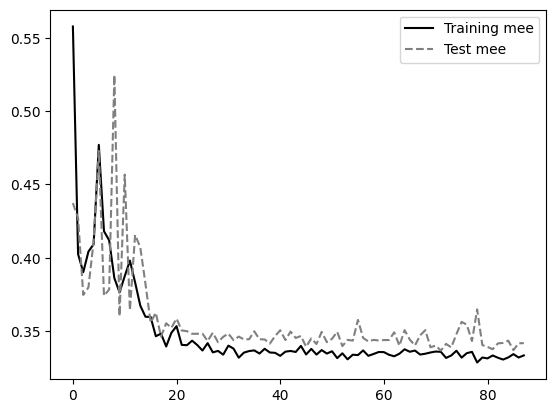

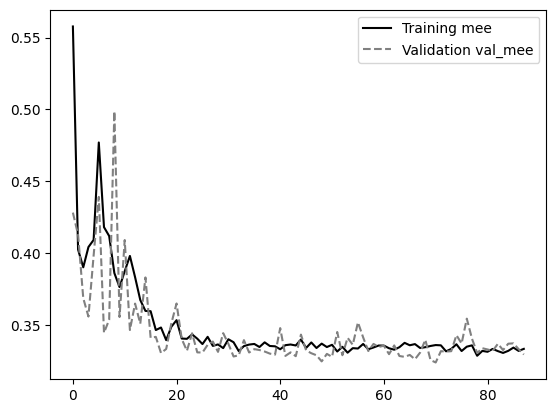

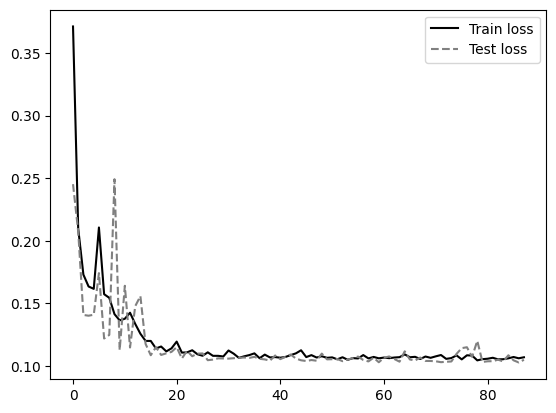

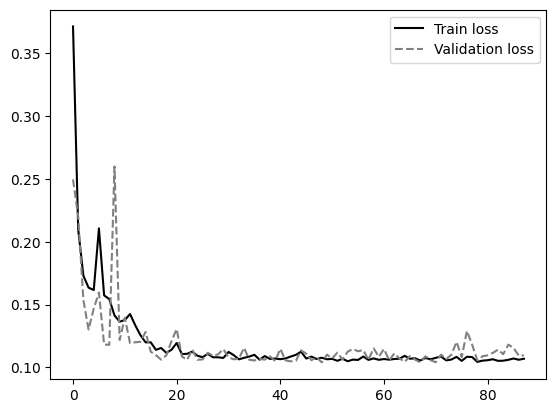

8/8 [==============================] - 0s 2ms/step

Validation MSE: 4.207394347200502
Validation MEE: 1.638668230911381
10/10 [==============================] - 0s 2ms/step
Train MSE: 4.058433482709122
Train MEE: 1.6430651934268266
Test MSE: 4.000889553563396
Test MEE: 1.6419689498131531


In [7]:
model = grid_search(params, x_train, y_train, x_test, y_test, hold_out_val)
assess_model(model, x_train, y_train, x_test, y_test, True)

In [113]:
model.save("./../models/keras_model.hdf5")

38/38 [==============================] - 0s 1ms/step


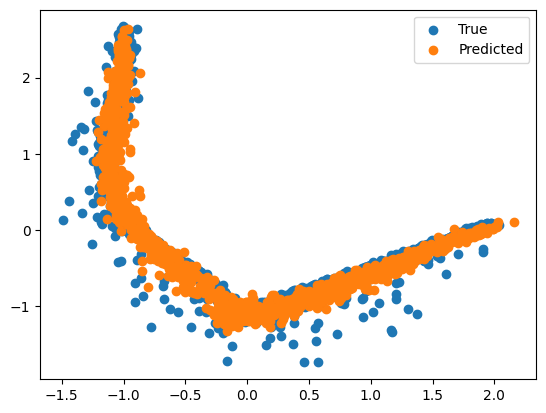

In [141]:
# y_train_rescaled = scaler.inverse_transform(y_train)
# print(y_train.shape)

plt.scatter(y_train[:, 0], y_train[:, 1], label="True")
pred = model.predict(x_train)
# pred = scaler.inverse_transform(pred)
plt.scatter(pred[:, 0], pred[:, 1], label = "Predicted")
plt.legend()
plt.show()

10/10 [==============================] - 0s 2ms/step


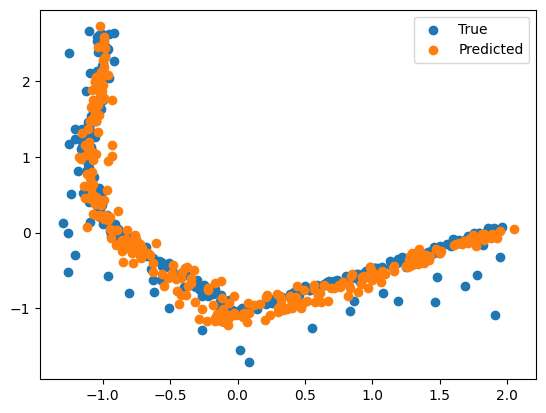

In [142]:
plt.scatter(y_test[:, 0], y_test[:, 1], label="True")
pred = model.predict(x_test)
# pred = scaler.inverse_transform(pred)
plt.scatter(pred[:, 0], pred[:, 1], label = "Predicted")
plt.legend()
plt.show()